Tobias Kuhlmann, Karlsruhe Institute of Technology (KIT), tobias.kuhlmann@student.kit.edu

In [13]:
%matplotlib inline

# Pretty Display of Variables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Double resolution plotting for retina display
%config InlineBackend.figure_format ='retina'

import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt

import glob
import os

import datetime as dt

## Data

##### Data needed
- Return time series to calculate rolling window stock-stock correlations $\rho^{P}_{ij,t}$
- Stock weights in index over time $w_{i,t}$
- Implied volatilities of every single stock i $\sigma^{Q}_{i,t}$
- Implied volatilities of Index $\sigma^{Q}_{M,t}$
- Use stock-stock correlations, implied volatilities of single stocks and index implied volatility to calculate $\alpha_t$


In [14]:
# Validate relative file path and list files
os.listdir("../Option_Implied_Beta_Tobias/")

['Single_Stock_Skewness',
 'Fundamentals_SP500_Full.xlsx',
 'usdOIScurve.csv',
 '.DS_Store',
 '0_Paper',
 'Calculation_Process2.ipynb',
 '2019_04_26_Cpy_Python_Code-Skewness_v8.ipynb',
 'processed_data',
 'instrumentid_and_symbol.csv',
 'SP500',
 'CRAMnoarbEOD_USOPT0007588D1_measuresByMaturity.csv',
 '.ipynb_checkpoints']

###### Import instrument id on ticker mapping

In [3]:
id_ticker_map = pd.read_csv("../Option_Implied_Beta_Tobias/instrumentid_and_symbol.csv")
id_ticker_map.shape
id_ticker_map.head(1)


(7590, 3)

,instrumentid,symbol,name
0,USOPT0000001D1,1R,NFX (OPIS) Mont Belvieu Non-LST Propane Future


## Reuters stock data approach

##### Stock prices
- All instrument prices in long format
- SP500 prices: Handle leaver and joiners
- Are the price series already filtered by active membership in SP500? Or just the full price series without the necessity of constantly being a SP500 member

In [4]:
# the path to csv file directory
mycsvdir = '../Option_Implied_Beta_Tobias/SP500/SP500 Prices/'
# get all the csv files in that directory
csvfiles_w_path = glob.glob(os.path.join(mycsvdir, '*.csv'))

In [5]:
# loop through the files and read them in with pandas
stock_prices = pd.DataFrame(columns=['id', 'Date', 'CLOSE']) 
for csvfile in csvfiles_w_path:
    df = pd.read_csv(csvfile, usecols=['Date', 'CLOSE'])
    # add column with ticker symbol
    filename_wo_ext=os.path.basename(csvfile)
    df['id'] = os.path.splitext(filename_wo_ext)[0]
    # append
    stock_prices = stock_prices.append(df[['id', 'Date', 'CLOSE']])
    
stock_prices.shape
print(f"Unique ticker labels: {stock_prices.id.unique().shape}")

(4123715, 3)

Unique ticker labels: (871,)


##### Stock price data quality and validation


Problems with stock price data:
 - Every date should have around 500 constituents (right now 505 because of different stock types per company)
  - Some dates with 1 (min) instrument and some with 630 (max)
 

In [6]:
print(f"Minimum constituent count per date: {stock_prices.groupby(by='Date').count().sort_values(by='id', ascending=True).head(1).id.values}")
print(f"Maximum constituent count per date: {stock_prices.groupby(by='Date').count().sort_values(by='id', ascending=False).head(1).id.values}")

Minimum constituent count per date: [1]
Maximum constituent count per date: [630]


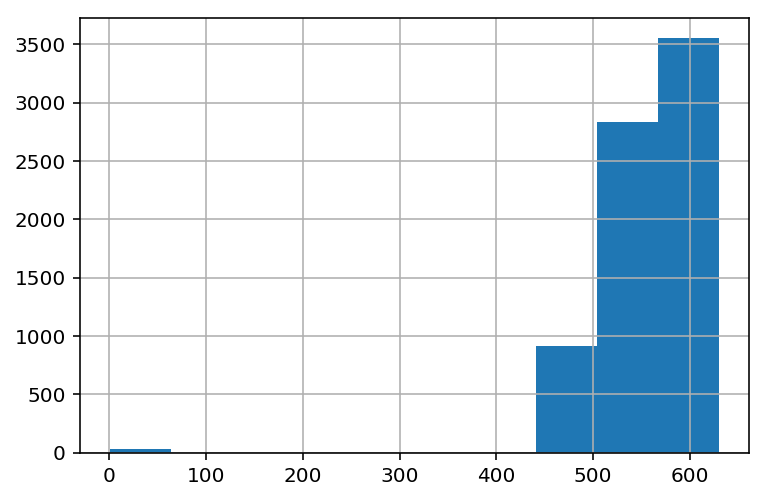

In [7]:
stock_prices.groupby(by='Date').count().id.hist()

##### SP500 constituent filtering
- Make sure leavers and joiners are adequately handled
 - Time series should only consist of dates where instrument is part of SP500
 
1. Attach beginning constituents to leaver joiners sheet
2. Create active membership time series for every ticker symbol
3. Filter time series on read in by those dates and delete rest in long format

In [8]:
leavers_joiners = pd.read_csv('../Option_Implied_Beta_Tobias/SP500/Constituents/2018_12_20_SP500_leavers_joiners.csv', 
                              usecols=['Date', 'Constituent RIC', 'type'])
leavers_joiners.head(1)
leavers_joiners.shape

,Date,Constituent RIC,type
0,1994-12-30T00:00:00Z,MDP.N,joiner


(1846, 3)

This shows the problematic that some instruments join and leave the SP500 more than once. Which means we need the full datetime series to adequately filter valid constituents by their membership dates

In [9]:
leavers_joiners.groupby(by='Constituent RIC').count().sort_values(by='type', ascending=False).head(2)

,Date,type
Constituent RIC,,
JCI.N,5,5
RX.N^C10,4,4


In [10]:
leavers_joiners_wo_duplic = pd.read_csv('../Option_Implied_Beta_Tobias/SP500/Constituents/2018_12_20_SP500_ljc_without_duplicates.csv', 
                                       usecols=['Constituent RIC'])
leavers_joiners_wo_duplic.head()
leavers_joiners_wo_duplic.shape

,Constituent RIC
0,MDP.N
1,SO.N
2,VO.N^L00
3,CVX.N
4,TMC.N^F00


(1144, 1)

##### Filter stock price data
 - Create time series of active membership dates for every instrument
 - Join imported prices on these time series 
 - Should give a little more than 500 constituents at every date

##### Stock weights in index over time 

- Problem: In SP500 fundamentals excel sheet only current market cap, need free float market cap

S&P 500 index is free-float market capitalization weighted. 
Free-float weighted means that instead of full market cap, only the public float of the company is considered when calculating its weight. Not all the shares of a company can be traded freely but some stocks might be under restrictions from SEC. S&P Dow Jones is assigning IWF (Investable Weight Factor) for all components part of its US indexes based on the component’s float

References: 
- https://us.spindices.com/documents/index-policies/methodology-sp-float-adjustment.pdf
- http://siblisresearch.com/data/weights-sp-500-companies/


##### Weight calculation using the Float Adjustment Methodology of SP Dow Jones Indices
For each constituent i calculate free float market capitalization (FFMC): $$FFMC_{i,t} = {\#(free\ float\ shares)}_{i,t} * p_{i,t}$$

Then the respective index weight is the constituent's free float market capitalization $FFMC_{i,t}$ divided by the index' free float market capitalization $\sum_{i=1}^{N}{}FFMC_{i,t}$, which is the sum of all constituents market capitalizations.
$$w_{i,t} = \frac{FFMC_{i,t}}{\sum_{i=1}^{N}{}FFMC_{i,t}}$$





## Fundamentals excel approach
- For now, not from Reuters directly but from Simon's excel sheet with current market cap, not free float methodology
- Bring SP500 fundamental data into nice long format

In [13]:
# read in full SP500 fundamentals
# runtime around 15min with 2,9 GHz Intel Core i5, 8gb ram
sp_fund_full = pd.read_excel('../Option_Implied_Beta_Tobias/Fundamentals_SP500_Full.xlsx', 
                             index_col=0,
                             header=[3,5])

In [14]:
# stack to long format, twice for two index levels
sp_fund_long = sp_fund_full.stack(dropna=True).stack(dropna=True)
# reset index to work with valid long format
sp_fund_long = sp_fund_long.reset_index()
# clear column names
sp_fund_long.rename(columns={"level_0": "date", "Dates": "field", 'level_2': 'id', 0: 'value'}, inplace=True)
# filter price and market cap 
sp_fund_long = sp_fund_long[(sp_fund_long['field']=='PX_LAST') | (sp_fund_long['field']=='CUR_MKT_CAP')]

# Transform back to wide format to do calculations
sp_fund_wide = sp_fund_long.set_index(['date', 'id', 'field']).unstack()
#drop second column level
sp_fund_wide.columns = sp_fund_wide.columns.droplevel(0)

##### Calculate index constituents weights
- Calculate daily weight of every constituent $$w_{i,t}=\frac{MKTCAP_{i,t}}{\sum_{i=1}^{N}MKTCAP_{i,t}}$$
where $MKTCAP_{i,t}$ is the market capitalization of constituent $i$ at time $t$.

In [15]:
# prepare index for correct join operation
sp_fund_wide = sp_fund_wide.reset_index().set_index('date')
# join cummulative market cap
sp_fund_wide['INDEX_MKT_CAP'] = sp_fund_wide.groupby(by=['date']).agg({'CUR_MKT_CAP': ['sum']})
# Calculate weight
sp_fund_wide['weight'] = sp_fund_wide['CUR_MKT_CAP'].divide(sp_fund_wide['INDEX_MKT_CAP'])


In [16]:
sp_fund_long_output = pd.melt(sp_fund_wide.reset_index(), id_vars=['date', 
                                             'id'], 
                                    value_vars=['CUR_MKT_CAP', 
                                                'PX_LAST',
                                                'INDEX_MKT_CAP',
                                                'weight'])
sp_fund_long_output.head(2)

,date,id,field,value
0,2001-01-01,A UN Equity,CUR_MKT_CAP,24802.5721
1,2001-01-01,AAPL UW Equity,CUR_MKT_CAP,4996.2446


##### Export to csv

In [17]:
sp_fund_long_output.to_csv('../Option_Implied_Beta_Tobias/processed_data/sp500_stock_data.csv', index=True)

##### Data validation
- around 505 constituents per day
- Weights sum up to 1 per day
- Duplicate indices

##### Dupplicate indices: Shouldn't exist

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1751f94a8>]]


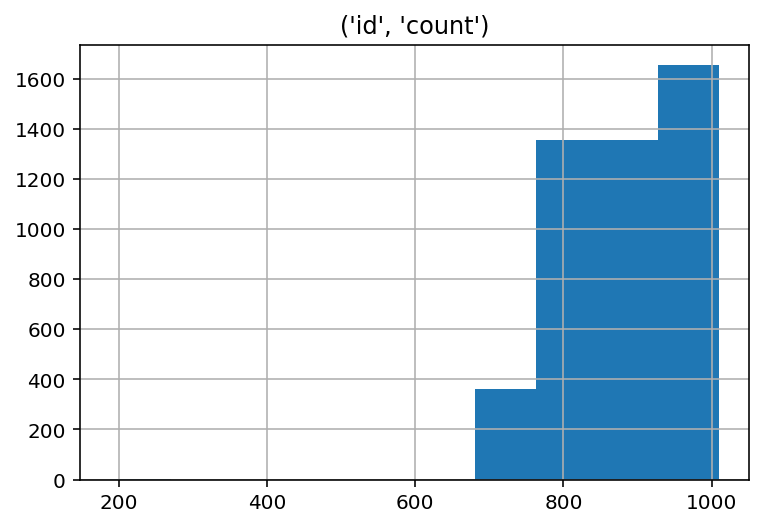

In [41]:
print(sp_fund_long.groupby(by=['date']).agg({'id': ['count']}).hist())
assert (sp_fund_wide.groupby(by=['date']).agg({'weight': ['sum']}).round(decimals=2) == 1.00).all().values, 'Weights don\'t add up to 1.00'
assert sp_fund_long[sp_fund_long.duplicated()].shape[0] == 0


##### Read in data from above

##### Rolling window stock-stock correlations $\rho^{P}_{ij,t}$ under empirical measure P

In [18]:
sp500_prices = pd.read_csv("../Option_Implied_Beta_Tobias/processed_data/sp500_stock_data.csv")
sp500_prices.head()
sp500_prices.shape

array(['CUR_MKT_CAP', 'PX_LAST', 'INDEX_MKT_CAP', 'weight'], dtype=object)

,Unnamed: 0,date,id,field,value
0,0,2001-01-01,A UN Equity,CUR_MKT_CAP,24802.5721
1,1,2001-01-01,AAPL UW Equity,CUR_MKT_CAP,4996.2446
2,2,2001-01-01,ADBE UW Equity,CUR_MKT_CAP,13984.9407
3,3,2001-01-01,ADSK UW Equity,CUR_MKT_CAP,1519.2750
4,4,2001-01-01,ALXN UW Equity,CUR_MKT_CAP,1169.9335


(8382268, 5)

In [21]:
sp500_prices = sp500_prices[sp500_prices.field == 'PX_LAST']
sp500_prices.head()
sp500_prices.id.unique().shapefast


,Unnamed: 0,date,id,field,value
2095567,2095567,2001-01-01,A UN Equity,PX_LAST,34.4172
2095568,2095568,2001-01-01,AAPL UW Equity,PX_LAST,0.9344
2095569,2095569,2001-01-01,ADBE UW Equity,PX_LAST,28.9129
2095570,2095570,2001-01-01,ADSK UW Equity,PX_LAST,6.5486
2095571,2095571,2001-01-01,ALXN UW Equity,PX_LAST,16.2344


(505,)

##### Calculate daily log returns from prices

NameError: name 'sp_fund_wide' is not defined

In [ ]:

#constituents_returns = prices_joined.pct_change(1)
constituents_log_returns = np.log(prices_joined/prices_joined.shift(1))

##### Rolling window stock-stock correlations $\rho^{P}_{ij,t}$ under empirical measure P
- rolling window correlations of log returns: rolling window = 252

In [ ]:
constituents_corr = constituents_log_returns.rolling(window=252).corr()